In [1]:
from feature_engineering.processing import *
from feature_engineering.engineering import *
from joblib import load
import warnings
warnings.filterwarnings('ignore')
pipeline_processing = load('../feature_engineering/pipelines/processing_pipeline.joblib')
pipeline_engineering = load('../feature_engineering/pipelines/engineering_pipeline.joblib')

In [2]:
X_train = pd.read_csv('../data/orig_train.csv')

y_train = X_train['DEFAULT_FLAG']
X_train.drop(columns=['DEFAULT_FLAG'], inplace=True)


pipeline_processing.fit(X_train)
X_train = pipeline_processing.transform(X_train)
pipeline_engineering.fit(X_train)
X_train = pipeline_engineering.transform(X_train)

In [3]:
X_val = pd.read_csv('../data/orig_valid.csv')

y_val = X_val['DEFAULT_FLAG']
X_val.drop(columns=['DEFAULT_FLAG'], inplace=True)

X_val = pipeline_processing.transform(X_val)
X_val = pipeline_engineering.transform(X_val)

## Model comparison

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 
from sklearn.svm import SVC

In [5]:
from matplotlib import pyplot as plt
from sklearn import metrics
def roc_curve_plot(models, X_train, y_train, X_val, y_val):
    plt.figure(0).clf()
    plt.figure(figsize=(8, 8))
    plt.title("ROC Curve for Different Models (Validation Data)")
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_val, y_pred)
        auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
        model_name = model.__class__.__name__  
        plt.plot(fpr, tpr, label=f"{model_name}, AUC={auc}")
    plt.legend()        

In [6]:
models = [DecisionTreeClassifier(), 
          MLPClassifier(),
          GaussianNB(), 
          GradientBoostingClassifier(), 
          AdaBoostClassifier(),
          RandomForestClassifier(),
         LogisticRegression(),
         XGBClassifier(),
         SVC(probability=True)]

In [7]:
from tabulate import tabulate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
def calculate_metrics(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    return accuracy, recall, precision, f1

def print_metrics(models, X_train, y_train, X_val, y_val):
    results = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])
    for model in models:
        accuracy, recall, precision, f1 = calculate_metrics(model, X_train, y_train, X_val, y_val)
        results.loc[len(results)] = {'Model': model.__class__.__name__,
                                        'Accuracy': accuracy,
                                        'Recall': recall,
                                        'Precision': precision,
                                        'F1 Score': f1}
    print(tabulate(results, headers='keys', tablefmt='simple'))

#### Score comparison for training data

In [8]:
print('Training data')
print_metrics(models, X_train, y_train, X_train, y_train)

Training data
    Model                         Accuracy      Recall    Precision    F1 Score
--  --------------------------  ----------  ----------  -----------  ----------
 0  DecisionTreeClassifier        1         1              1          1
 1  MLPClassifier                 0.967411  0.47338        0.91704    0.624427
 2  GaussianNB                    0.681327  0.790509       0.128553   0.221143
 3  GradientBoostingClassifier    0.946943  0.0868056      0.862069   0.157729
 4  AdaBoostClassifier            0.942174  0.0474537      0.450549   0.0858639
 5  RandomForestClassifier        1         1              1          1
 6  LogisticRegression            0.943366  0.0115741      0.909091   0.0228571
 7  XGBClassifier                 0.986951  0.777778       0.992614   0.872161
 8  SVC                           0.943234  0.00810185     1          0.0160735


#### Score comparison for validation data

In [9]:
print('Validation data')
print_metrics(models, X_train, y_train, X_val, y_val)

Validation data
    Model                         Accuracy      Recall    Precision    F1 Score
--  --------------------------  ----------  ----------  -----------  ----------
 0  DecisionTreeClassifier        0.928903  0.556757       0.410359   0.472477
 1  MLPClassifier                 0.939104  0.156757       0.414286   0.227451
 2  GaussianNB                    0.765997  0.718919       0.158711   0.26002
 3  GradientBoostingClassifier    0.943431  0.0702703      0.541667   0.124402
 4  AdaBoostClassifier            0.943431  0.0540541      0.555556   0.0985222
 5  RandomForestClassifier        0.953323  0.205405       0.904762   0.334802
 6  LogisticRegression            0.943431  0.0108108      1          0.0213904
 7  XGBClassifier                 0.958269  0.324324       0.857143   0.470588
 8  SVC                           0.943122  0.00540541     1          0.0107527


This data set is not balanced so a better option to choose the right model is to compare ROC curves, AUC and GINI.
These metrics will inform us whether a model correctly ordered the observations according to the probabilities of consumers defaulting on a loan. According to those probabilities decision about giving a loan would be made.

#### ROC curve for different models

<Figure size 640x480 with 0 Axes>

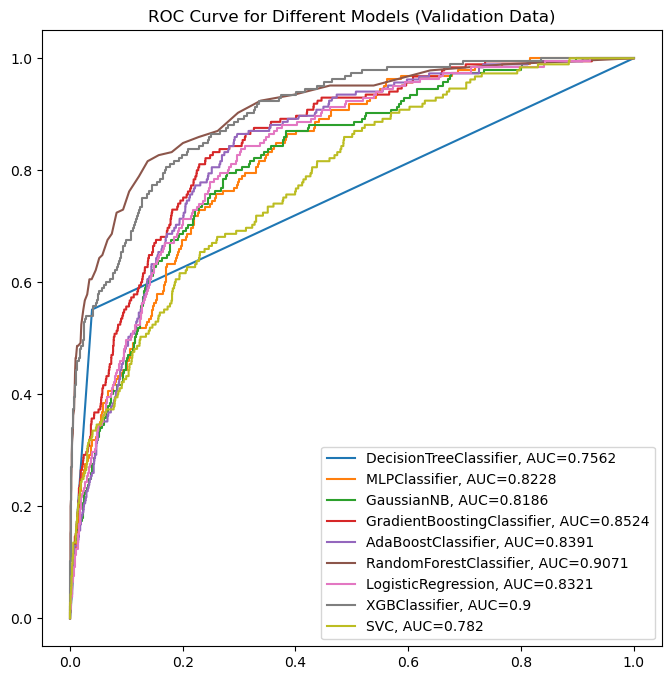

In [10]:
roc_curve_plot(models, X_train, y_train, X_val, y_val)

RandomForestClassifier and XGBClassifier have the best AUC scores. We will try to improve them by tuning the parameters.

## Tuning hyperparameters 

In [9]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

def hyperparameters_tuning(param_grid, model, folds, param_comb, X, y, rand=True):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)

    if rand:
        search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=param_comb,
                                    scoring='roc_auc', random_state=1001, cv=skf.split(X, y))
    else:
        search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=skf.split(X, y))

    search.fit(X, y)

    print('\n Best estimator:')
    print(search.best_estimator_)
    print('\n Best normalized gini score:')
    print(search.best_score_ * 2 - 1)
    print('\n Best hyperparameters:')
    print(search.best_params_)

#### RandomForest

In [10]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

hyperparameters_tuning(param_grid=param_grid, model=RandomForestClassifier(), folds=5, param_comb=100, X=X_train, y=y_train)


 Best estimator:
RandomForestClassifier(max_depth=20, n_estimators=200)

 Best normalized gini score:
0.7795632414836953

 Best hyperparameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


We will keep *min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None* but we will AUC and GINI by different numbers of estimators.

Best gini score: 0.8349827204253433, for 1700 estimators.


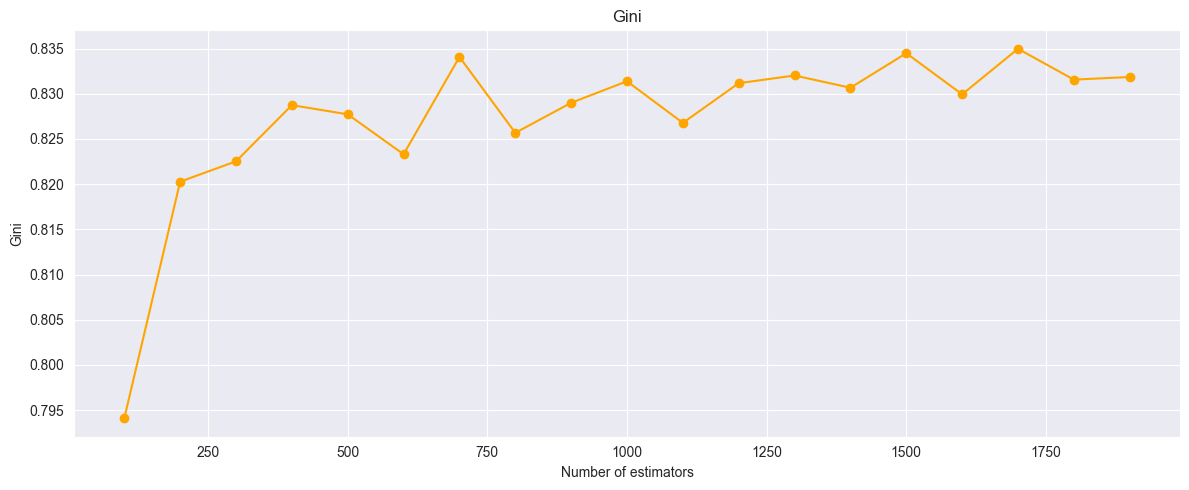

In [19]:
from sklearn.metrics import roc_auc_score

def compare_n_estimators(estimators, X_train, y_train, X_val, y_val):
    gini_scores = []
    num_estimators = []
    max_gini = 0
    max_estimator = 0
    
    for n in estimators:
        model = RandomForestClassifier(n_estimators=n, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None)

        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred_proba)
        gini = 2 * auc - 1

        gini_scores.append(gini)
        num_estimators.append(n)
        
        if gini > max_gini:
            max_gini = gini
            max_estimator = n
     
    print(f'Best gini score: {max_gini}, for {max_estimator} estimators.')   
    plt.figure(figsize=(12, 5))
    plt.plot(num_estimators, gini_scores, marker='o', color='orange')
    plt.xlabel('Number of estimators')
    plt.ylabel('Gini')
    plt.title('Gini')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

estimators = [100 * i for i in range(1, 20)]
compare_n_estimators(estimators, X_train, y_train, X_val, y_val)

#### XGBoost

In [12]:
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 4, 5],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'min_child_weight': [1, 5, 10],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}


hyperparameters_tuning(param_grid=param_grid, model=XGBClassifier(), folds=5, param_comb=100, X=X_train, y=y_train)


 Best estimator:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

 Best normalized gini score:
0.7480004609764417

 Best hyperparameters:
{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 0.5, 'colsample_bytree': 0.6}


We got max_depth = 5, gamma = 0.5 and colsample = 0.6, min_child_weigth = 1 and these values are maximal or minimal from our grid, so it suggest us to search again, in different ranges.

In [16]:
param_grid = {
    'max_depth': [5, 6, 7],
    'gamma': [0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [0.1, 0.25, 0.5, 0.75, 1],
    'colsample_bytree': [0.1, 0.3, 0.6],
    'subsample': [0.6, 0.8, 1.0]
}


hyperparameters_tuning(param_grid=param_grid, model=XGBClassifier(), folds=5, param_comb=100, X=X_train, y=y_train)


 Best estimator:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.75, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

 Best normalized gini score:
0.7646285165424209

 Best hyperparameters:
{'subsample': 0.8, 'min_child_weight': 0.75, 'max_depth': 7, 'gamma': 0.5, 'colsample_bytree': 0.6}


We got better results. Now lets use GridSearch to check more carefully promising parameter space.

In [17]:
param_grid = {
    'max_depth': [5, 6],
    'gamma': [0.1, 0.15, 0.2],
    'min_child_weight': [0.15, 0.2, 0.25],
    'colsample_bytree': [0.5, 0.6],
    'subsample': [0.8, 1]
}

# 2 * 3 * 3 * 2 * 2 = 72 combinations

hyperparameters_tuning(param_grid=param_grid, model=XGBClassifier(), folds=5, param_comb=None, X=X_train, y=y_train, rand= False)


 Best estimator:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=0.2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

 Best normalized gini score:
0.7684441034543259

 Best hyperparameters:
{'colsample_bytree': 0.5, 'gamma': 0.1, 'max_depth': 6, 'min_child_weight': 0.2, 'subsample': 1}


Slightly better performance.